# SOLUTION TO THE PROJECT TRAFFIC SIGN CLASSIFIER.


### Questions to be answered in this project following the rubric.
- 1)  Summary of the given dataset.
- 2)  Vizualization of the given dataset.
- 3)  What are the pre-porcessing techniques used and why?
- 4)  Summarize the train and test data setup, data augmentation methods.
- 5)  How does the final architecture of the setup look like, and why?. Give a visual feed.
- 6)  HOW WAS THE MODEL TRAINED, which optimizer is used and why, what is the batch size, number of epochs, and hyperparameters.
- 7)  What are the approaches followed towards a solution to the stated problem. How good is the final approach (based on the         percentage of accuracy).
- 8)  Test the model on five new German trafffic sign images from web.
- 9)  Is the model able to perform equally well on captured pictures or a live camera stream when compared to testing on the           dataset.
- 10) Use the model's softmax probabilities to visualize the certainty of its predictions, tf.nn.top_k could prove helpful here.       Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the             correct prediction appear in the top k? (k should be 5 at most)
- 11) If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired           images.
- 12) Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for           interesting characteristics in traffic sign images 

### Steps followed sequentially during the exection of the classifier system:
#### Step 1: Data Exploration.
#### Step 2: Visualize the Data and Summarize the data.
#### Step 3: Design and Test a model Architecture.
#### Step 4: Test the model on new Images.
#### Step 5: Store the Model for future use.
#### Step 6: Summarize the entire solution.
#### Step 7: Acknowledgements and sources.

## Step 1 : Data Exploration:
First we need to familiarize ourselves with the dataset. This problem deals with the dataset of German Traffic Signs. During data exploration we need to see if the datasets are well balenced, because if they are no so, the model can get biased towards a class with higher number of images, which is to be avoided.

In [1]:
# import the required libraries and packages
import numpy as np
import tensorflow as tf
import cv2
import csv
import pickle
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec #check step:7 #http://matplotlib.org/users/gridspec.html
import os
import sys
#import time as time
from timeit import default_timer as timer # check step:7 #https://docs.python.org/2/library/timeit.html
import random
from sklearn.preprocessing import OneHotEncoder # check step:7 #http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
#from sklearn.cross_validation import train_test_split, this is depricated in tensorflow 1.0 and used as .model_selection method.
from sklearn.model_selection import train_test_split
from PIL import Image as pimag
from IPython.display import Image as ipimag
from IPython.display import display as ipdis
import pandas as pd
import prettytensor as pt # checkstep:7 # https://github.com/google/prettytensor
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix # check step:7 #http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

# var init
indir = 'traffic_sign_data'
outdir = 'modelsol'
sess = tf.InteractiveSession() # check step:7 #https://www.tensorflow.org/versions/r0.11/api_docs/python/client/session_management#InteractiveSession
SEED = 200
random.seed(SEED) # http://stackoverflow.com/questions/22639587/random-seed-what-does-it-do
np.random.seed(SEED)
tf.set_random_seed(SEED) # https://www.tensorflow.org/api_docs/python/tf/set_random_seed
%matplotlib inline

In [2]:
#  LOAD THE DATA
def load_data(trainf,testf,signf): 
    training_file  = indir +'/'+trainf
    testing_file   = indir +'/'+testf
    classnames_file = indir +'/'+signf

    classnames = []
    with open(classnames_file) as _f:
        rows = csv.reader(_f, delimiter=',')
        next(rows, None)  # skip the headers
        for i, row in enumerate(rows):
            assert(i==int(row[0]))
            classnames.append(row[1])
 
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    X_train, y_train = train['features'], train['labels']
    X_test, y_test   = test['features'], test['labels']
    
    
    X_train  = X_train.astype(np.float32)
    y_train  = y_train.astype(np.int32)
    X_test   = X_test.astype(np.float32)
    y_test   = y_test.astype(np.int32)
    
    return  classnames, X_train, y_train, X_test, y_test

In [ ]:
def OHE_labels(Y_tr,N_classes):
    OHC = OneHotEncoder()
    
    Y_ohc = OHC.fit(np.arange(N_classes).reshape(-1, 1))
    Y_labels = Y_ohc.transform(Y_tr.reshape(-1, 1)).toarray()
    return Y_labels

In [ ]:
labels_train = OHE_labels(y_train,43)
labels_test = OHE_labels(y_test,43)

In [ ]:
def check_OHE(cls,y):
    check = np.linalg.norm(np.argmax(cls,axis=1)-y)
    if check == 0:
        print('One hot encoding correct, ok to proceed')
    else:
        print('One hot encoding doesnt match the output, check code!!!')


In [ ]:
check_OHE(labels_test,y_test)
check_OHE(labels_train,y_train)

In [ ]:
#image normalization
#image = image/255.-.5

Given: The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [3]:
# Getting dataset parameters.
classnames, X_train, y_train, X_test, y_test = load_data(trainf='train.p',testf='test.p',signf='signnames.csv') 
# Save Original Test for future evaluation
#X_test_orig = X_test
#y_test_orig = y_test
 
# TODO: Number of training examples 
num_train = len(X_train)

# TODO: Number of testing examples.
num_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
_, height, width, channel = X_train.shape
image_shape = (height, width, channel)

# TODO: How many unique classes/labels there are in the dataset.
num_class = len(np.unique(y_train))


print("Number of training examples =", num_train )
print("Number of testing examples =", num_test )
print("Image data shape =", image_shape)
print("Number of classes =", num_class)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Now, we know that our dataset has 43 classes and train/test is approximately = 3, the image shape is 32x32x3.

## Step 2: Visualize and summarize the data


-  Q1) Visualize the given data.
-  Q2) Summarize the given data
- Answers to these questions are written in markdown cell after visualizing the data.

In [4]:
# Sorting the given train data in ascending order with labels as keys.
data_i = [[i,sum(y_train == i)] for i in range(len(np.unique(y_train)))]
data_sorted = sorted(data_i, key=lambda x: x[1])
sorted_data = [data_sorted[i][0] for i in range(len(data_sorted))]
print(sorted_data)

[0, 19, 37, 27, 32, 41, 42, 24, 29, 21, 39, 20, 40, 22, 36, 6, 16, 34, 30, 23, 28, 15, 26, 33, 14, 31, 17, 18, 35, 11, 3, 8, 7, 9, 25, 5, 4, 10, 38, 12, 13, 1, 2]


In [5]:
# A helper function designed to plot the images.
def insert_subimage(image, sub_image, y, x): 
    h, w, c = sub_image.shape
    image[y:y+h, x:x+w, :]=sub_image 
    return image

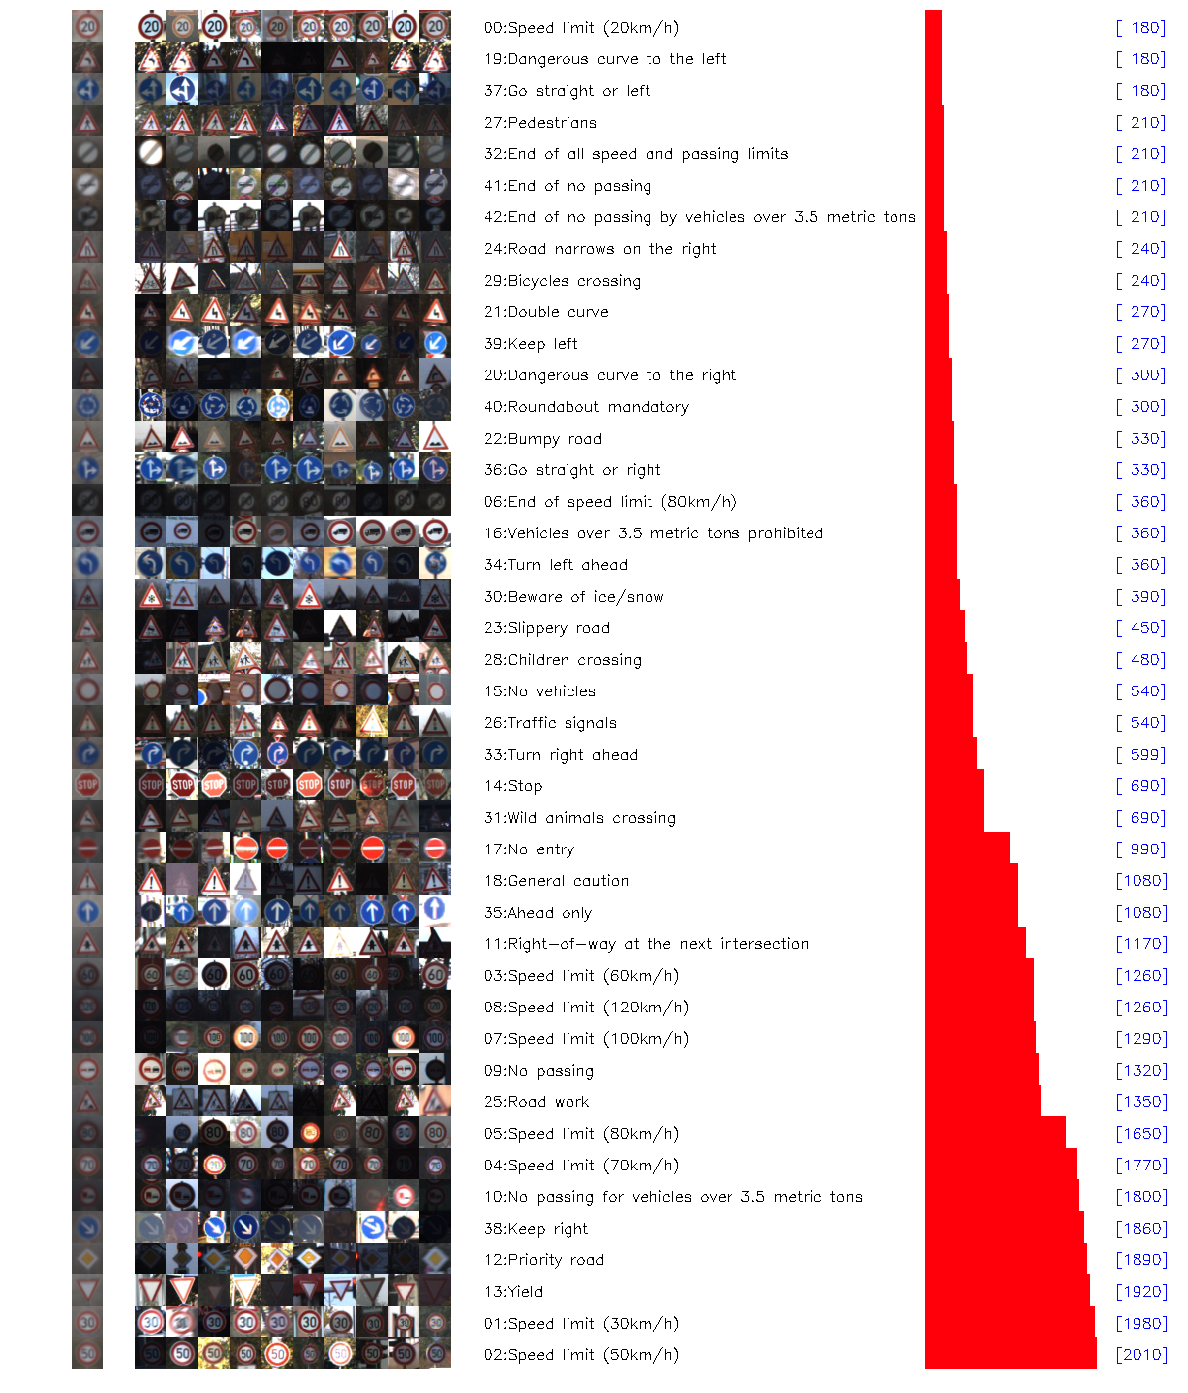

Column [1]: Mean image for the data set corresponding to the respective image label
Column [2-11]: 10 Sample images
Column [12]: Sign label and Sign name
Column [13]: HISTOGRAM of entire train dataset
Column [14]: Number of images per class


In [6]:
# Visualizing the train data.
images, labels = X_train, y_train

#results image, is the on over which rest sub images are drawn
num_sample=10
results_image = 255.*np.ones(shape=(num_class*height,(num_sample+4+22)*width, channel),dtype=np.float32)
z=0
for c in sorted_data:
    #make mean
    idx = list(np.where(labels== c)[0])
    mean_image = np.average(images[idx], axis=0)
    insert_subimage(results_image, mean_image, z*height, width)


    #make random sample
    for n in range(num_sample):
        sample_image = images[np.random.choice(idx)]
        insert_subimage(results_image, sample_image, z*height, (3+n)*width)

    #print summary
    count=len(idx)
    percentage = float(count)/float(len(images))
    cv2.putText(results_image, '%02d:%-6s'%(c, classnames[c]), ((4+num_sample)*width, int((z+.7)*height)),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)
    cv2.putText(results_image, '[%4d]'%(count), ((2+num_sample+22)*width, int((z+0.7)*height)),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1)
    cv2.rectangle(results_image,((2+num_sample+16)*width, z*height),((2+num_sample+16)*width + round(percentage*3000), (z+1)*height),(255,0,10),-1)
    z+=1

# Save image to outdir
cv2.imwrite(outdir+'/train_data_summary.jpg',cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))



plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(results_image.astype(np.uint8))
plt.axis('off') 
plt.show()

print('Column [1]: Mean image for the data set corresponding to the respective image label')
print('Column [2-11]: 10 Sample images')
print('Column [12]: Sign label and Sign name')
print('Column [13]: HISTOGRAM of entire train dataset')
print('Column [14]: Number of images per class')

### Visualization Summary:
The mean images look fine for every class, so it might not be too difficult to train the classifier. By looking at the sample images it is clear that brightness is varied largley across the data which should be handled. It is also clear from the histogram that the number of images per class are not equal, so data augmentation is necessary. 



### Step 3 : Design and Test a model Architecture.

- Q3) What are the pre-porcessing techniques used and why?
- Q4) Summarize the train and test data setup, data augmentation methods.
- Q5) How does the final architecture of the setup look like, and why?. Give a visual feed.
- Q6) HOW WAS THE MODEL TRAINED, which optimizer is used and why, what is the batch size, number of epochs, and hyperparameters.
- Q7) What are the approaches followed towards a solution to the stated problem. How good is the final approach (based on the         percentage of accuracy).

Answers to these questions are written along the proceess of design and testing the classifier.

#### Data pre-processing
Some of the ideas were inspired from the detail from https://arxiv.org/abs/1606.02228 . This paper gave a good understanding and description about the architecture and hyperparameters for a network.This paper also gives a verygood overview of CNN architectures https://arxiv.org/pdf/1511.02992.pdf .
- The image is not converted to grayscale as COLOR is one important feature for traffic signs along with geometrics.
- Histogram equilization on the input image didnot bring improvement in training accuracy but lead to loss during validation.
- Initial normalization and stadardization did hurt the performance as well.
###### ** So, no pre-processing is done on the entire dataset at once, but only create new data that is like the transformed version of current for data augmentation. The data augmentation is done by transforming the images, transformations are performed to change the orientation, to shift, to shear and to enhace the image in terms of its brightness, contrast and saturation.**
- The above mentioned methods are only applied with a certain range, for example the image is rotated randomly only in the         range of roughly  +- 40. The idea of image flipping is also considered to be a good data augmentation technique(but all   the classes donot obey a single mirror plane, as the classes are based on geometrics of the image).

In [16]:
# We work on the copy of dataset rather than on dataset itself. o_ represents original copy.
Xo_train, yo_train, Xo_test, yo_test = X_train, y_train, X_test, y_test

In [8]:
# Combine train and test into one dataset and split it later on

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [9]:
# Define a function to show the class distributions when needed
def show_classes_distribution(labels, title = None):
    # Count classes samples
    uniq_labels = sorted(set(labels.tolist()))
    #print(uniq_labels)
    n_labels = len(uniq_labels)
    class_counts = np.zeros([n_labels])
    for c in uniq_labels:
        class_counts[c] = np.sum(labels == c)
    y_pos = np.arange(n_labels)
    plt.figure(figsize=(18, 5))
    plt.bar(uniq_labels, class_counts)
    plt.xticks(y_pos)
    plt.ylabel('Classes Counts')
    if title: plt.title(title)


In [10]:
# This part of code is borrowed from http://navoshta.com/traffic-signs-classification/
# Flipping the images to gain more train data.
def extend_data_by_flipping(images, labels):

    X=images
    y=labels

    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    # Classes of signs that, when flipped vertically, should still be classified as the same class
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    # Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
    self_flippable_both = np.array([32, 40])
    # Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38],
    ])
    num_classes = 43

    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype=np.float32)
    y_extended = np.empty([0], dtype=np.int32)

    for c in range(num_classes):
        # First copy existing data for this class
        X_extended = np.append(X_extended, X[y == c], axis=0)
        # If we can flip images of this class horizontally and they would still belong to said class...
        if c in self_flippable_horizontally:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis=0)
        # If we can flip images of this class horizontally and they would belong to other class...
        if c in cross_flippable[:, 0]:
            # ...Copy flipped images of that other class to the extended array.
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis=0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype=np.int32))

        # If we can flip images of this class vertically and they would still belong to said class...
        if c in self_flippable_vertically:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis=0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype=np.int32))

        # If we can flip images of this class horizontally AND vertically and they would still belong to said class...
        if c in self_flippable_both:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis=0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype=np.int32))

    extend_datas  = X_extended
    extend_labels = y_extended
    return (extend_datas, extend_labels)

In [11]:
#flip the data
train_images, train_labels = extend_data_by_flipping(X, y)
num_train_flip = len(train_images)
print(num_train_flip)

81508


In [12]:
def perturb(image, keep, angle_limit=15, scale_limit=0.1, translate_limit=3, distort_limit=3, illumin_limit=0.7):

    u=np.random.uniform()
    if u>keep :
        #geometric -------------
        (W, H, C) = image.shape
        center = np.array([W / 2., H / 2.])
        da = np.random.uniform(low=-1, high=1) * angle_limit/180. * math.pi
        scale = np.random.uniform(low=-1, high=1) * scale_limit + 1

        cc = scale*math.cos(da)
        ss = scale*math.sin(da)
        rotation    = np.array([[cc, ss],[-ss,cc]])
        translation = np.random.uniform(low=-1, high=1, size=(1,2)) * translate_limit
        distort     = np.random.standard_normal(size=(4,2)) * distort_limit

        pts1 = np.array([[0., 0.], [0., H], [W, H], [W, 0.]])
        pts2 = np.matmul(pts1-center, rotation) + center  + translation

        #add perspective noise
        pts2 = pts2 + distort


        #http://milindapro.blogspot.jp/2015/05/opencv-filters-copymakeborder.html
        matrix  = cv2.getPerspectiveTransform(pts1.astype(np.float32), pts2.astype(np.float32)) 
        perturb = cv2.warpPerspective(image, matrix, (W, H), flags=cv2.INTER_LINEAR,
                                      borderMode=cv2.BORDER_REFLECT_101)  # BORDER_WRAP  #BORDER_REFLECT_101  #cv2.BORDER_CONSTANT  BORDER_REPLICATE

        #illumination -------------
        #from mxnet code
        
        #brightness
        alpha = 1.0 + illumin_limit*random.uniform(-1, 1)
        perturb *= alpha
        perturb = np.clip(perturb,0.,255.)
        pass

        #contrast
        coef = np.array([[[0.299, 0.587, 0.114]]]) #rgb to gray (YCbCr) :  Y = 0.299R + 0.587G + 0.114B

        alpha = 1.0 + illumin_limit*random.uniform(-1, 1)
        gray = perturb * coef
        gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
        perturb *= alpha
        perturb += gray
        perturb = np.clip(perturb,0.,255.)
        pass

        #saturation
        coef = np.array([[[0.299, 0.587, 0.114]]]) #rgb to gray (YCbCr) :  Y = 0.299R + 0.587G + 0.114B

        alpha = 1.0 + illumin_limit*random.uniform(-1, 1)
        gray = perturb * coef
        gray = np.sum(gray, axis=2, keepdims=True)
        gray *= (1.0 - alpha)
        perturb *= alpha
        perturb += gray
        perturb = np.clip(perturb,0.,255.)
        pass

        return perturb

    else:
        return image

In [13]:
from scipy import ndimage
def transform_image(image,ang_range=30,shear_range=0.2,trans_range=3):
    (W, H, C) = image.shape
    pts1 = np.array([[0., 0.], [0., H], [W, H], [W, 0.]])

    # Rotation

    ang_rot = np.random.uniform(low= -ang_range,high=ang_range)
    rows,cols,ch = image.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    image = cv2.warpAffine(image,Rot_M,(cols,rows))
    image = cv2.warpAffine(image,Trans_M,(cols,rows))
    image = cv2.warpAffine(image,shear_M,(cols,rows))
    IM = image
    return IM
def random_gaussian_filter(img):
    sigma = np.random.choice([0.2,0.5,0.7,1])
    return ndimage.gaussian_filter(img, sigma=sigma)


len_X = 47429
len_y = 47429
class_counts = [  240.  2700.  2760.  1710.  2430.  2280.   510.  1740.  1710.  1800.
  2460.  1590.  2580.  2640.   960.   750.   510.  1350.  1470.   240.
   390.   360.   450.   600.   330.  1830.   720.   270.   630.   330.
   540.   960.   270.   809.   480.  1470.   450.   240.  2550.   360.
   390.   270.   300.]
max_num = 2760.0
min_num = 240.0
errors = 0
len_X = 118680
len_y = 118680


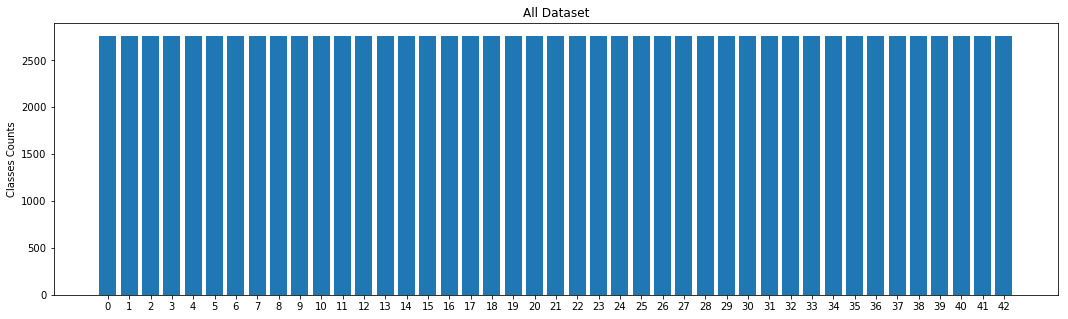

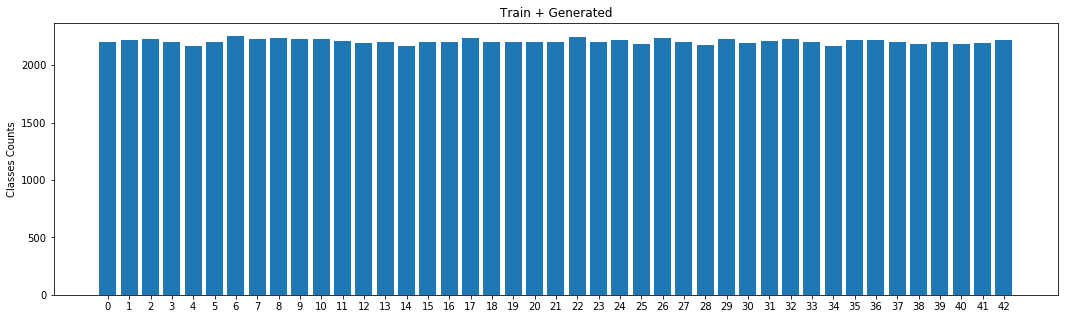

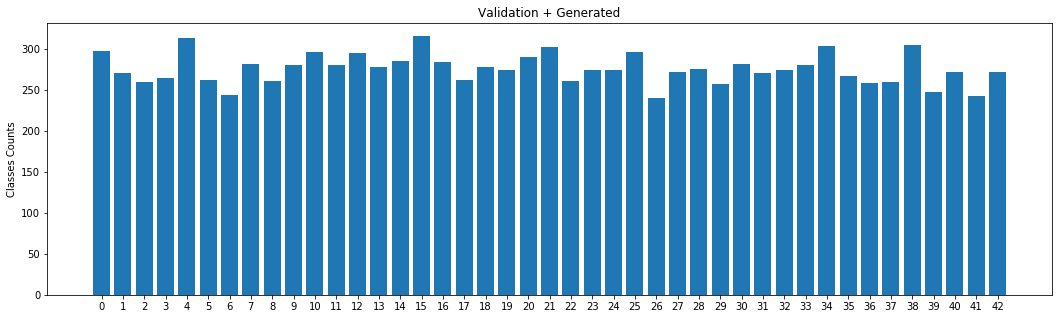

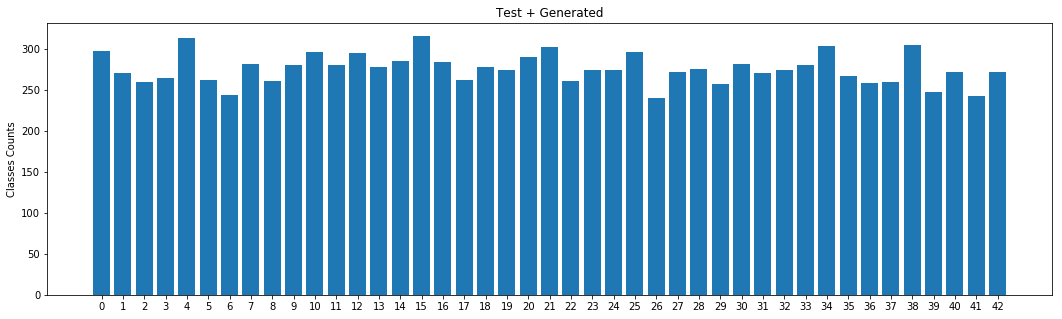

In [14]:
def generate_images(X, y):
    # Count classes samples
    uniq_labels = sorted(set(y.tolist()))
    n_labels = len(uniq_labels)
    class_counts = np.zeros([n_labels])
    
    all_ind = np.arange(len(y))
    img_indices = {}
    for c in uniq_labels:
        class_counts[c] = np.sum(y == c)
        img_indices[c] = all_ind[y == c]
    
    print("len_X =", len(X))
    print("len_y =", len(y))
    print("class_counts =", class_counts)
        
    max_num = np.max(class_counts)
    min_num = np.min(class_counts)
    print("max_num =", max_num)
    print("min_num =", min_num)

    errors =0
    for c in range(n_labels):
        c_num = np.sum(y == c)
        num = max_num - c_num
        nimgs = []
        nimgs_labels = []
        
        num_range = range(int(num)) # tqdm progress
        
        for n in num_range:
            sample = np.random.choice(img_indices[c])
            try:
                nimg = perturb(X[sample],keep=0)
            except:
                errors += 1
                nimg = random_gaussian_filter(X[sample])
            nimgs.append(nimg)
            nimgs_labels.append(c)
            
        if len(nimgs) > 0:
            X = np.append(X, np.array(nimgs), axis=0)
            y = np.append(y, nimgs_labels)
            class_counts[c] += num

    print("errors =", errors)
    return X, y
    
X1, y1 = generate_images(X, y)
show_classes_distribution(y1, 'All Dataset')



# Split Data into Train/Validation/Test
def train_validation_test(X, y):
    # Shuffle it
    r_idx = np.random.permutation(len(X))
    print("len_X =", len(X))
    print("len_y =", len(y))
    X = X[r_idx]
    y = y[r_idx]

    # Train/Valid/Test distributions
    p_train = 0.8
    p_valid = 0.1
    p_test = 0.1

    # Sanity check
    assert p_train + p_valid + p_test == 1.0

    N = len(X)
    train_idx = int(N*p_train)
    valid_idx = int(N*(p_train+p_valid))
    X_train = X[:train_idx]
    y_train = y[:train_idx]
    X_valid = X[train_idx:valid_idx]
    y_valid = y[train_idx:valid_idx]
    X_test = X[valid_idx:]
    y_test = y[valid_idx:]
                
    assert len(X_train) + len(X_valid) + len(X_test) == N
    assert len(y_train) + len(y_valid) + len(y_test) == N

    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = train_validation_test(X1, y1)


show_classes_distribution(y_train, 'Train + Generated')
show_classes_distribution(y_test, 'Validation + Generated')
show_classes_distribution(y_test, 'Test + Generated')

In [ ]:
'''try:
    with open(X_train.pickle, 'wb') as f:
        pickle.dump(X_train, f, pickle.HIGHEST_PROTOCOL)

except Exception as e:
    print('Unable to save data to', X_train.pickle, ':', e)'''

In [ ]:
'''#number of images per class
uniq_labels = sorted(set(y_train.tolist()))
n_labels = len(uniq_labels)
clcount_train = np.zeros([n_labels])
clcount_test = np.zeros([n_labels])
for c in uniq_labels:
    clcount_train[c] = np.sum(y_train == c)
    clcount_test[c] = np.sum(y_test == c)
print('train:',clcount_train,'test:',clcount_test)'''



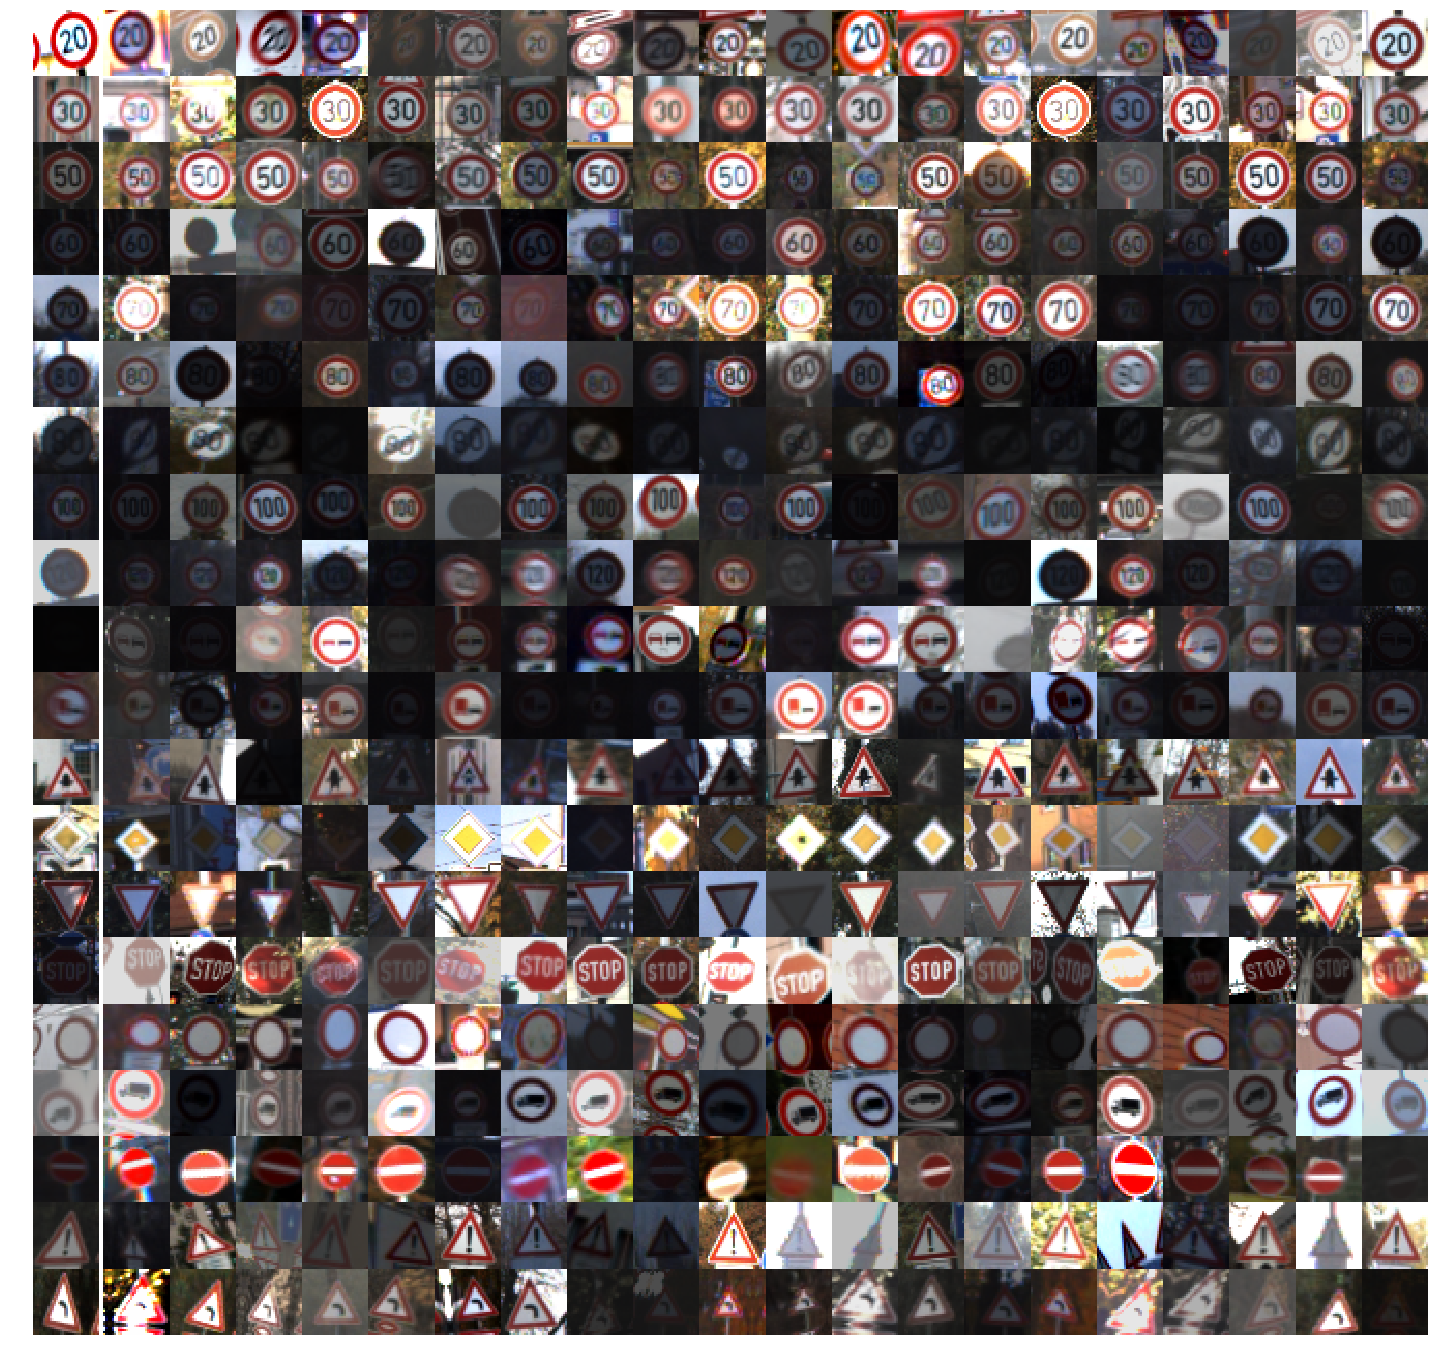

In [17]:
images, labels = X_train, y_train
imageso, labelso = Xo_train, yo_train
num_train_flip = len(Xo_train)
num_sample = 20
perturbance_per_sample = 20

results_image = 255. * np.ones(shape=(num_sample * height, (perturbance_per_sample+1)* width+2, channel),dtype=np.float32)

for j in range(num_sample):
    i = random.randint(0, num_train_flip - 1)
    idx = list(np.where(labels== j)[0])
    idxo = list(np.where(labelso==j)[0])

    image = imageso[np.random.choice(idxo)]
    insert_subimage(results_image, image, j * height, 0)

    for k in range(0, perturbance_per_sample):
        t_image = images[np.random.choice(idx)]
        insert_subimage(results_image, t_image, j*height, (k+1)*width+2)

         
cv2.imwrite(outdir+'/data_transform.jpg',cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(results_image.astype(np.uint8))
plt.axis('off') 
plt.show()
    

In [23]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# we define the basic ops first -----------------------------------------

##  global varaiables ##
IS_TRAIN_PHASE = tf.placeholder(dtype=tf.bool, name='is_train_phase')

def conv2d(input, num_kernels=1, kernel_size=(1,1), stride=[1,1,1,1], padding='SAME', has_bias=True, name='conv'):

    input_shape = input.get_shape().as_list()
    assert len(input_shape)==4
    C = input_shape[3]
    H = kernel_size[0]
    W = kernel_size[1]
    K = num_kernels

    ##[filter_height, filter_width, in_channels, out_channels]
    w    = tf.get_variable(name=name+'_weight', shape=[H, W, C, K], initializer=tf.truncated_normal_initializer(stddev=0.1))
    conv = tf.nn.conv2d(input, w, strides=stride, padding=padding, name=name)
    if has_bias:
        b = tf.get_variable(name=name + '_bias', shape=[K], initializer=tf.constant_initializer(0.0))
        conv = conv+b

    return conv


def relu(input, name='relu'):
    act = tf.nn.relu(input, name=name)
    return act

def prelu(input, name='prelu'):
  alpha = tf.get_variable(name=name+'_alpha', shape=input.get_shape()[-1],
                       #initializer=tf.constant_initializer(0.25),
                        initializer=tf.random_uniform_initializer(minval=0.1, maxval=0.3),
                        dtype=tf.float32)
  pos = tf.nn.relu(input)
  neg = alpha * (input - abs(input)) * 0.5

  return pos + neg


# very leaky relu
def vlrelu(input, alpha=0.25, name='vlrelu'): #  alpha between 0.1 to 0.5
    act =tf.maximum(alpha*input,input)
    return act

def maxpool(input, kernel_size=(1,1), stride=[1,1,1,1], padding='SAME', has_bias=True, name='max' ):
    H = kernel_size[0]
    W = kernel_size[1]
    pool = tf.nn.max_pool(input, ksize=[1, H, W, 1], strides=stride, padding=padding, name=name)
    return pool

def avgpool(input, kernel_size=(1,1), stride=[1,1,1,1], padding='SAME', has_bias=True, is_global_pool=False, name='avg'):

    if is_global_pool==True:
        input_shape = input.get_shape().as_list()
        assert len(input_shape) == 4
        H = input_shape[1]
        W = input_shape[2]

        pool = tf.nn.avg_pool(input, ksize=[1, H, W, 1], strides=[1,H,W,1], padding='VALID', name=name)
        pool = flatten(pool)

    else:
        H = kernel_size[0]
        W = kernel_size[1]
        pool = tf.nn.avg_pool(input, ksize=[1, H, W, 1], strides=stride, padding=padding, name=name)

    return pool


def dropout(input, keep=1.0, name='drop'):
    #drop = tf.cond(IS_TRAIN_PHASE, lambda: tf.nn.dropout(input, keep), lambda: input)
    drop = tf.cond(IS_TRAIN_PHASE,
                   lambda: tf.nn.dropout(input, keep),
                   lambda: tf.nn.dropout(input, 1))
    return drop


def flatten(input, name='flat'):
    input_shape = input.get_shape().as_list()        # list: [None, 9, 2]
    dim   = np.prod(input_shape[1:])                 # dim = prod(9,2) = 18
    flat  = tf.reshape(input, [-1, dim], name=name)  # -1 means "all"
    return flat

def concat(input, name='cat'):
    cat = tf.concat(axis=3, values=input, name=name)
    return cat


#https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/api_docs/python/functions_and_classes/shard4/tf.contrib.layers.batch_norm.md
#http://www.bubufx.com/detail-1792794.html
def bn (input, decay=0.9, eps=1e-5, name='bn'):
    with tf.variable_scope(name) as scope:
        bn = tf.cond(IS_TRAIN_PHASE,
            lambda: tf.contrib.layers.batch_norm(input,  decay=decay, epsilon=eps, center=True, scale=True,
                              is_training=1,reuse=None,
                              updates_collections=None, scope=scope),
            lambda: tf.contrib.layers.batch_norm(input, decay=decay, epsilon=eps, center=True, scale=True,
                              is_training=0, reuse=True,
                              updates_collections=None, scope=scope))

    return bn


In [24]:
# basic building blocks

def conv2d_bn_relu(input, num_kernels=1, kernel_size=(1,1), stride=[1,1,1,1], padding='SAME', name='conv'):
    with tf.variable_scope(name) as scope:
        block = conv2d(input, num_kernels=num_kernels, kernel_size=kernel_size, stride=stride, padding=padding, has_bias=False)
        block = bn(block)
        block = relu(block)
    return block


def bn_relu_conv2d (input, num_kernels=1, kernel_size=(1, 1), stride=[1, 1, 1, 1], padding='SAME', name='conv'):
    with tf.variable_scope(name) as scope:
        block = bn(input)
        block = relu(block)
        block = conv2d(block, num_kernels=num_kernels, kernel_size=kernel_size, stride=stride, padding=padding, has_bias=False)
    return block



# modified dense block from the paper [1] "Densely Connected Convolutional Networks" - Gao Huang, Zhuang Liu, Kilian Q. Weinberger, 
# Laurens van der Maaten, Arxiv 2016
# Modification: 
#   1. the paper uses bn-relu-conv but we use conv-bn-relu
#   2. the paper uses dropout inside the block but we shift the dropout outside the block see network construction later
def dense_block_cbr (input, num=1, num_kernels=1, kernel_size=(1, 1), drop=None, name='DENSE'):
 
    block = input
    for n in  range(num):
        with tf.variable_scope(name+'_%d'%n) as scope:
            conv = conv2d(block, num_kernels=num_kernels, kernel_size=kernel_size, stride=[1,1,1,1], padding='SAME', has_bias=False)
            conv = bn(conv)
            conv = relu(conv)

            if drop is not None:
                keep = (1 - drop) ** (1. / num)
                conv = dropout(conv, keep=keep)

            block = concat((block, conv))
    return block


In [25]:
# the loss 
def l2_regulariser(decay):

    variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    for v in variables:
        name = v.name
        if 'weight' in name:  #this is weight
            l2 = decay * tf.nn.l2_loss(v)
            tf.add_to_collection('losses', l2)
        elif 'bias' in name:  #this is bias
            pass
        elif 'beta' in name:
            pass
        elif 'gamma' in name:
            pass
        elif 'moving_mean' in name:
            pass
        elif 'moving_variance' in name:
            pass
        elif 'moments' in name:
            pass

        else:
            #pass
            #raise Exception('unknown variable type: %s ?'%name)
            pass

    l2_loss = tf.add_n(tf.get_collection('losses'))
    return l2_loss


def cross_entropy(logit, label, name='cross_entropy'):
    label = tf.cast(label, tf.int64)
    cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logit, label), name=name)
    return cross_entropy


def accuracy(prob, label, name='accuracy'):
    correct_prediction = tf.equal(tf.argmax(prob, 1), tf.cast(label, tf.int64))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name=name)
    return accuracy


In [26]:
# my densenet here!
#the inference part (without loss)

def DenseNet_3( input_shape=(1,1,1), output_shape = (1)):

    H, W, C   = input_shape
    num_class = output_shape
    input     = tf.placeholder(shape=[None, H, W, C], dtype=tf.float32, name='input')

    #color preprocessing using conv net:
    #see "Systematic evaluation of CNN advances on the ImageNet"-Dmytro Mishkin, Nikolay Sergievskiy, Jiri Matas, ARXIV 2016
    # https://arxiv.org/abs/1606.02228
    # we use learnable prelu (different from paper) and 3x3 onv
    with tf.variable_scope('preprocess') as scope:
        input = bn(input, name='b1')
        input = conv2d(input, num_kernels=8, kernel_size=(3, 3), stride=[1, 1, 1, 1], padding='SAME', has_bias=True, name='c1')
        input = prelu(input, name='r1')
        input = conv2d(input, num_kernels=8, kernel_size=(1, 1), stride=[1, 1, 1, 1], padding='SAME', has_bias=True, name='c2')
        input = prelu(input, name='r2')


    with tf.variable_scope('block1') as scope:
        block1 = conv2d_bn_relu(input, num_kernels=32, kernel_size=(5, 5), stride=[1, 1, 1, 1], padding='SAME')
        block1 = maxpool(block1, kernel_size=(2,2), stride=[1, 2, 2, 1], padding='SAME')

    # we use conv-bn-relu in DENSE block (different from paper)
    # dropout is taken out of the block
    with tf.variable_scope('block2') as scope:
        block2 = dense_block_cbr(block1, num=4, num_kernels=16, kernel_size=(3, 3), drop=None)
        block2 = maxpool(block2, kernel_size=(2, 2), stride=[1, 2, 2, 1], padding='SAME')

    with tf.variable_scope('block3') as scope:
        block3 = dense_block_cbr(block2, num=4, num_kernels=24, kernel_size=(3, 3), drop=None)
        block3 = dropout(block3, keep=0.9)
        block3 = maxpool(block3,  kernel_size=(2,2), stride=[1, 2, 2, 1], padding='SAME')

    with tf.variable_scope('block4') as scope:
        block4 = dense_block_cbr(block3, num=4, num_kernels=32, kernel_size=(3, 3), drop=None)
        block4 = conv2d_bn_relu(block4, num_kernels=num_class, kernel_size=(1,1), stride=[1, 1, 1, 1], padding='SAME')
        block4 = dropout(block4, keep=0.9)
        block4 = avgpool(block4, is_global_pool=True)


    logit = block4
    return logit


In [28]:
# construct the graph here
make_net = DenseNet_3  #LeNet_0  #LeNet_1

logit  = make_net(input_shape =(height, width, channel), output_shape=(num_class))
data   = tf.get_default_graph().get_tensor_by_name('input:0')
label  = tf.placeholder(dtype=tf.int32, shape=[None])
prob   = tf.nn.softmax(logit)

l2     = l2_regulariser(decay=0.0005)
loss   = cross_entropy(logit, label)
metric = accuracy(prob, label)

ValueError: Variable preprocess/c1_weight already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1264, in __init__
    self._traceback = _extract_stack()
  File "C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)


In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

# changing of learning rate
def schdule_by_step( r, steps=(0,100), items=(0.1,0.01)):

    item = items[0]
    N=len(steps)
    for n in range(N):
        if r >= steps[n]:
            item = items[n]
    return item


#for testing and validation
def test_net( datas, labels, batch_size, data, label, loss, metric, sess):

    num = len(datas)
    all_loss = 0
    all_acc = 0
    all = 0
    for n in range(0, num, batch_size):
        #print('\r  evaluating .... %d/%d' % (n, num), end='', flush=True)
        start = n
        end = start+batch_size if start+batch_size<=num else num
        batch_datas  = datas  [start:end]
        batch_labels = labels [start:end]

        fd = {data: batch_datas, label: batch_labels, IS_TRAIN_PHASE : False}
        test_loss, test_acc = sess.run([loss, metric], feed_dict=fd)

        a = end-start
        all += a
        all_loss += a*test_loss
        all_acc  += a*test_acc

    assert(all==num)
    loss = all_loss/all
    acc  = all_acc/all

    return loss, acc


In [ ]:
#solver 
epoch_log  = 2 
max_run    = 9
batch_size = 128  #256  #96  384  #128
steps = (0, 3, 6, 8)  
rates = (0.1, 0.01,  0.001, 0.0001) 

learning_rate = tf.placeholder(tf.float32, shape=[])
solver = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
solver_step = solver.minimize(loss+l2)



# start training here ------------------------------------------------
print ('start training')
sess.run(tf.global_variables_initializer(), feed_dict = {IS_TRAIN_PHASE : True } )
saver  = tf.train.Saver()
#writer = tf.summary.FileWriter(out_dir + '/tf', graph=tf.get_default_graph())


# keep a log   
print('')
print(' run  epoch   iter    rate      |  train_loss    (acc)     |  valid_loss    (acc)     |  time ')
print('----------------------------------------------------------------------------------------------')

tic = timer()
iter = 0
for r in range(max_run):
    rate = schdule_by_step(r, steps=steps, items=rates)

    argument_images, argument_labels = shuffle_data_uniform(train_images, train_labels, num_class,  num_per_class=num_per_class)
    argument_images = make_perturb_images(argument_images, keep=keep)


    num_argument = len(argument_images)
    N = max(num_argument//batch_size-1,1)
    #iter_log = round(float(num_train) / float(num_argument) * float(N))
    iter_log = max(round(float( epoch_log *num_train ) / float(batch_size)),1)
    for n in range(N):
        iter  = iter + 1
        run   = r + float(n)/float(N)
        epoch = float(iter*batch_size)/float(num_train)

        batch_datas, batch_labels = generate_train_batch_next( argument_images, argument_labels, n, batch_size )

        fd = {data: batch_datas, label: batch_labels, learning_rate: rate, IS_TRAIN_PHASE : True }
        _, batch_loss, batch_acc, = sess.run([solver_step, loss, metric ],feed_dict=fd)

      
        print('\r%4.1f  %5.1f   %05d   %f |  %f    (%f)  ' %
                  (run, epoch, iter, rate, batch_loss, batch_acc), end='', flush=True)

        #do validation here!
        if iter%iter_log==0 or (r==max_run-1 and n==N-1): 
            toc = timer()
            sec_pass = toc - tic
            min_pass = sec_pass/60.

            #validation
            val_loss, val_acc =  test_net(valid_images, valid_labels, batch_size, data, label, loss, metric, sess)

            #print('\r')
            print('\r%4.1f  %5.1f   %05d   %f |  %f    (%f) |  %f    (%f) | %4.1f min' %
                  (run, epoch, iter, rate, batch_loss, batch_acc, val_loss, val_acc, min_pass ), end='\n',flush=True)


        pass

    # save intermediate checkpoint
    # saver.save(sess, out_dir + '/check_points/%06d.ckpt'%r)  #iter


#final test! ------------------------------------------
# save final checkpoint
os.makedirs (OUT_DIR + '/check_points/final.ckpt',exist_ok=True)
saver.save(sess, OUT_DIR + '/check_points/final.ckpt')

print('\n') 
print('** evaluation on test set **' )
test_loss, test_acc = test_net(test_images, test_labels, batch_size, data, label, loss, metric, sess)
print('test_loss=%f    (test_acc=%f)' % ( test_loss, test_acc))

 


LAST BLOCK
CADENCE IMPLEMENTATION: https://ip.cadence.com/uploads/901/TIP_WP_cnn_FINAL-pdf